<a href="https://colab.research.google.com/github/Talos6/AIPI590-Occluding/blob/main/aipi590-Occluding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AIPI 590 - XAI | Assignment #07
### Description
Investigating the feature importance of the bottom half of MNIST digits on classification accuracy using a pre-trained ResNet34 model.
### Your Name
Xinyue(Yancey) Yang

[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Talos6/AIPI590-Occluding/blob/main/AIPI590-Occluding.ipynb)

## Hypothesis

**Null Hypothesis(H0)**: Skip the bottom half of an MNIST digit image does not result in a significantly different decrease in the model's classification accuracy.

**Alternative Hypothesis(H1)**: Skip the bottom half of an MNIST digit image results in a significantly larger decrease in the model's classification accuracy.

## Approach

We aim to evaluate the feature importance of bottom half of MNIST digit images. Which will follow these steps:

*   **Data**: MNIST dataset
*   **Pre-Processing**: resize image and turn into RGB.
*   **Model**: pre-trained ResNet34 model with fine-tune on MNIST.
*   **Occlusion**: Create occluded versions of the test images by masking the bottom half.
*   **Prediction**: Use the model to predict class probabilities on original and occluded images.
*   **Visualization**: Generate plots to illustrate the impact of occluding the bottom half on model confidence.



## Code

In [ ]:
# Load packages
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset
from scipy.stats import ttest_rel
import pandas as pd

In [ ]:
# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


In [ ]:
# Data pre-processing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
])

#Load MNIST dataset
train_dataset = datasets.MNIST(root='mnist_data', train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST(root='mnist_data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9.91M/9.91M [00:00<00:00, 18.0MB/s]


Extracting mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to mnist_data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28.9k/28.9k [00:00<00:00, 489kB/s]


Extracting mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to mnist_data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.47MB/s]


Extracting mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist_data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4.54k/4.54k [00:00<00:00, 6.02MB/s]

Extracting mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist_data/MNIST/raw



In [ ]:
# Load pre-trained ResNet34 model
model = models.resnet34(pretrained=True)

# Modify the final layer to output 10 classes
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)

model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Fine-tune the model
num_epochs = 3
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 143MB/s]


Epoch [1/3], Loss: 0.0764
Epoch [2/3], Loss: 0.0386
Epoch [3/3], Loss: 0.0306


In [ ]:
# Evaluate the model on test data
def evaluate_model(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    return accuracy

test_accuracy = evaluate_model(model, test_loader)
print(f'Original Test Accuracy: {test_accuracy:.4f}')

Original Test Accuracy: 0.9893


In [ ]:
# Prepare occlusion data
class OccludedDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        image = np.array(image.permute(1, 2, 0))
        image[112:, :, :] = 0
        image = torch.tensor(image).permute(2, 0, 1)
        return image, label

# Create occluded test dataset
occluded_test_dataset = OccludedDataset(test_dataset)
occluded_test_loader = DataLoader(occluded_test_dataset, batch_size=64, shuffle=False)

In [ ]:
# Evaluate the model on occluded test data
occluded_test_accuracy = evaluate_model(model, occluded_test_loader)
print(f'Occluded Test Accuracy: {occluded_test_accuracy:.4f}')

Occluded Test Accuracy: 0.5050


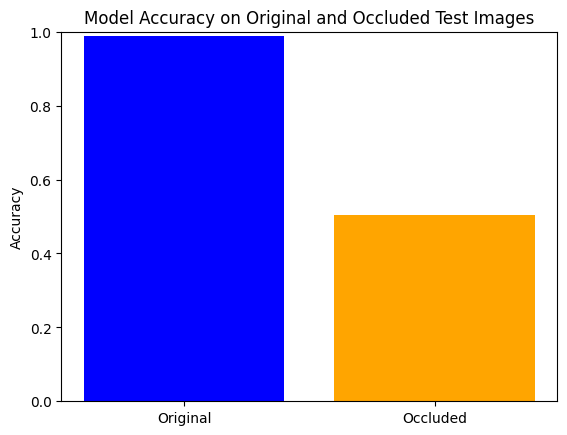

In [ ]:
# Visualization
accuracies = [test_accuracy, occluded_test_accuracy]
conditions = ['Original', 'Occluded']

plt.bar(conditions, accuracies, color=['blue', 'orange'])
plt.title('Model Accuracy on Original and Occluded Test Images')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.show()

## Visualization
The visualization above is the model accuracy value for both original and occluded test images. As we can clearly see that the model accuracy is 0.9893 for original images and the model accuracy is 0.5050 for occluded images. Which stands out an significantly decrease in the model accuracy when we occluded the bottom half of the image. It rejects the null hypothesis and indicating the bottom half of MNIST digit stands out to be a important feature towards the final prediction.

## Summary

As mentioned in both visualization and accuracy scores. The occluded bottom half images leads to a 48.95% decrease in the model classification accuracy, which is statistically significant and noticeable. It rejects H0 hypothesis and support H1 hypothesis indicating the bottom half of MNIST contains critical features that the model relies on.

In conclusion, occluding method is a good way to reveal the feature importance or determine which part of input shows significant contribution to the model decision making. We can also apply an further analysis that trying to narrow done the specific parts of image or features that contribute the most towards model prediction through multiple occluding. It helps to make the model more explanable as we can determine if the occluding part impose a significant effect or not.